# Schwinger Oscillator Experiments

In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pickle
import json

from qiskit_aer import Aer
from qiskit.converters import circuit_to_dag
from qiskit.compiler import transpile

In [2]:
from open_quantum_systems.schwinger import *

### Data Directory:

In [3]:
DATA_DIR = './data'

### Backend Configurations:

In [4]:
# Aer simulator configuration:
aer_backend = Aer.get_backend('aer_simulator')
aer_transpile_options = {
    'optimization_level' : 3,
    'approximation_degree' : 0.975
}

# IonQ configuration:
ionq_transpile_options = {
    'optimization_level' : 3,
    'approximation_degree' : 0.975
}

# IonQ Simulator configuration:
ionq_simulator_options = {
    "error-mitigation": {
        "debias": True
    },
        "noise": {
        "model": "harmony",
        "seed": 1000
    }
}

# IonQ QPU configuration:
ionq_real_qpu_options = {
    "error-mitigation": {
        "debias": True
    }
}

def save_data(job_data, filename):
    with open(os.path.join(DATA_DIR, filename), 'wb') as f:
        pickle.dump(job_data, f)

def load_data(filename):
    with open(os.path.join(DATA_DIR, filename), 'rb') as f:
        return pickle.load(f)

def save_json_data(job_array, filename):
    with open(os.path.join(DATA_DIR, filename), 'w') as f:
        f.write(json.dumps(job_array))

## 📝 **Configure Job Submission Here** 📝

To submit jobs on real quantum hardware, you will need to configure the following variables:

1. **`quantum_backend`**: Qiskit backend that will be targeted for transpilation. If the provider has a Qiskit backend, set this variable to the correct backend.
2. **`quantum_transpile_options`**: Options for the Qiskit transpiler. I would recommend the following options:
  * `{'optimization_level' : 3, 'approximation_degree' : 0.975 }`

In addition, you will also need to define the following functions:

3. **`launch_quantum_job(circuits, shots)`**:
    * This function submits a list of circuits to the provider, running each circuit with the given number of shots. The function must return a list of unique job identifiers (`job_array`), which can be saved and later used to retrieve the jobs from the provider. Currently this function returns an Aer job object to simulate submission to a server. You will need to change this to instead return a list of unique job ids for each submitted circuit (IDs in string format are preferred).

4. **`get_quantum_job_results(circuits, shots)`**:
    * This function retrieves the results corresponding to a list of unique job identifiers (i.e. the same `job_array` list that was returned from `launch_quantum_job`). The function must return a list of measurement count dictionaries corresponding to each unique id in `job_array`. For example, these dictionaries take the form: `{'00': 721, '01': 1327}`. This dictionary can easily be retrieved from a qiskit job object using the `result.get_counts()` function.
          

In [24]:
# 1. This is the backend that is targeted by Qiskit's transpiler/optimizer
quantum_backend = aer_backend

# 2. These are the transpiler options:
quantum_transpile_options = aer_transpile_options

# 3. This function submits a list of circuits and submits them to the provider and
#    returns a list of unique job ids.
def launch_quantum_job(circuits, shots):
    job_array = [
        quantum_backend.run(c, shots=shots) for c in circuits
    ]
        
    return job_array # <-- This should be a list of unique job ids (preferably strings)

# 4. This function retrieves the results jobs from the provider based on a list of job ids.
def get_quantum_job_results(job_array):

    result_counts = [
        job.result().get_counts()
        for job in job_array
    ]
    
    return result_counts # <-- This should be a list of measurement count dictionaries

quantum_primitive_kwargs = {
    'launch_job_fn' : launch_quantum_job,
    'get_result_fn' : get_quantum_job_results
}

### Experiment Parameters:

In [6]:
hbar = 1./(2*np.pi)
omega = 2*np.pi
gamma_xyz=[0,0,10]
mass = 1.0

In [7]:
t_range = (0,3)
t_classical_range = (0,5)
n_trajectory_samples = 5

n_shots = 1000

n_qubits = 1
kraus_order = 3
psi_0 = np.array([1,1j,1,0]) / np.sqrt(3)

In [8]:
sim = SchwingerOscillatorSimulation(n_qubits=n_qubits, 
                                    kraus_order=kraus_order,
                                    gamma_xyz=gamma_xyz,
                                    simultaneous=True,
                                    hbar=hbar,
                                    omega=omega)

## Experiment 1: 
$\hat{J}_y$-damped Schwinger Oscillators

In [9]:
t_classical = np.linspace(*t_classical_range,1000)
t_sample = np.linspace(*t_range,n_trajectory_samples)
t_ideal_sample = np.linspace(*t_range,3*(n_trajectory_samples-1)+1)

rhos_classical = sim.simulate_classical_density_matrix_evolution(initial_state=psi_0, t=t_classical)

### 1. Run Ideal Simulations:

In [10]:
rhos_ideal_quantum = np.array(
    sim.simulate_pure_state_density_evolution(
        pure_state=psi_0,
        t=t_ideal_sample,
        backend=aer_backend,
        shots=n_shots,
        renormalize=False,
        transpile_options=aer_transpile_options))

### 2. Submit Jobs:

In [11]:
# rhos_noisy_quantum_jobs = sim.simulate_pure_state_density_evolution(
#         pure_state=psi_0,
#         t=t_sample,
#         backend=quantum_backend,
#         shots=n_shots,
#         renormalize=False,
#         transpile_options=quantum_transpile_options,
#         primitive_kwargs=quantum_primitive_kwargs | dict(submit_jobs_only=True))

**Note**: The following cell will fail to run if you are using the Aer-based `launch_job` function, but you should still be able to run the rest of the notebook. If you have properly defined the `launch_job` function it will save the ids of submitted jobs so you can load them later on.

In [12]:
#save_data(rhos_noisy_quantum_jobs, 'schwinger_job.pkl')

### 3. Retrieve Job Results:

In [13]:
#rhos_noisy_quantum_jobs = load_data('schwinger_job.pkl')

In [14]:
# rhos_noisy_quantum = sim.simulate_pure_state_density_evolution(
#         pure_state=psi_0,
#         t=t_sample,
#         backend=quantum_backend,
#         shots=n_shots,
#         renormalize=False,
#         transpile_options=quantum_transpile_options,
#         primitive_kwargs=quantum_primitive_kwargs | dict(submitted_jobs_data=rhos_noisy_quantum_jobs)
#     )

In [15]:
#save_data(rhos_noisy_quantum, 'schwinger_data.pkl')

### 4. Visualize Job Results:

In [16]:
rhos_noisy_quantum = load_data('schwinger_data_h1.pkl')

In [17]:
x, y = sim.position_operators(m=mass, unitless=True)
px, py = sim.momentum_operators(m=mass, unitless=True)

H = sim.hamiltonian_operator()

x_classical_eval = np.trace(x@rhos_classical, axis1=-2, axis2=-1).real
y_classical_eval = np.trace(y@rhos_classical, axis1=-2, axis2=-1).real

x_ideal_eval = np.trace(x@rhos_ideal_quantum, axis1=-2, axis2=-1).real
y_ideal_eval = np.trace(y@rhos_ideal_quantum, axis1=-2, axis2=-1).real

x_noisy_eval = np.trace(x@rhos_noisy_quantum, axis1=-2, axis2=-1).real
y_noisy_eval = np.trace(y@rhos_noisy_quantum, axis1=-2, axis2=-1).real

px_classical_eval = np.trace(px@rhos_classical, axis1=-2, axis2=-1).real
py_classical_eval = np.trace(py@rhos_classical, axis1=-2, axis2=-1).real

px_ideal_eval = np.trace(px@rhos_ideal_quantum, axis1=-2, axis2=-1).real
py_ideal_eval = np.trace(py@rhos_ideal_quantum, axis1=-2, axis2=-1).real

px_noisy_eval = np.trace(px@rhos_noisy_quantum, axis1=-2, axis2=-1).real
py_noisy_eval = np.trace(py@rhos_noisy_quantum, axis1=-2, axis2=-1).real

In [18]:
from scipy.interpolate import interp1d
    

def damped_harmonic_spline(t, omega, x,y):
    logr = np.log(np.sqrt(x**2+y**2))
    theta_0 = np.arctan2(y[0],x[0])
    r_spline = lambda s : np.exp(np.interp(s,t,logr))
    return lambda t : (r_spline(t)*np.cos(omega*t+theta_0), r_spline(t)*np.sin(omega*t+theta_0))

x_traj_spline = damped_harmonic_spline(t_sample, omega, x_noisy_eval, y_noisy_eval)
x_interpolated, y_interpolated = x_traj_spline(t_classical)

p_traj_spline = damped_harmonic_spline(t_sample, omega, px_noisy_eval, py_noisy_eval)
px_interpolated, py_interpolated = p_traj_spline(t_classical)

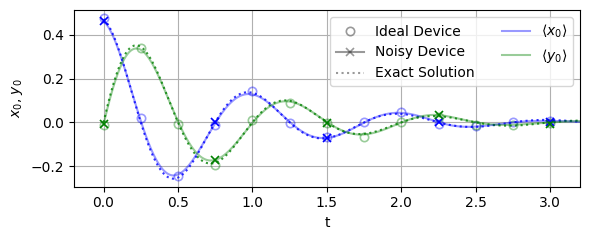

In [19]:
plt.figure(figsize=(6,2.5))
plt.plot(t_ideal_sample, x_ideal_eval, 'bo', fillstyle='none', markeredgewidth=1.2, alpha=0.4)
plt.plot(t_ideal_sample, y_ideal_eval, 'go', fillstyle='none', markeredgewidth=1.2, alpha=0.4)
plt.plot(t_sample, x_noisy_eval, 'bx', fillstyle='none', markeredgewidth=1.2)
plt.plot(t_sample, y_noisy_eval, 'gx', fillstyle='none', markeredgewidth=1.2)

plt.plot([],[], 'ko', fillstyle='none', markeredgewidth=1.2, alpha=0.4, label='Ideal Device')
plt.plot([],[], 'kx-', fillstyle='none', markeredgewidth=1.2, alpha=0.4, label='Noisy Device')
plt.plot([],[], 'k:', alpha=0.4, label='Exact Solution')


plt.plot(t_classical, x_classical_eval, 'b:', alpha=0.8)
plt.plot(t_classical, y_classical_eval, 'g:', alpha=0.8)

plt.plot(t_classical, x_interpolated, 'b', alpha=0.4, label=r'$\langle x_0 \rangle$')
plt.plot(t_classical, y_interpolated, 'g', alpha=0.4, label=r'$\langle y_0 \rangle$')

plt.xlim((np.min(t_sample)-0.2, np.max(t_sample)+0.2))
plt.xlabel('t')
plt.ylabel('$x_0$, $y_0$')
plt.legend(loc='upper right', ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

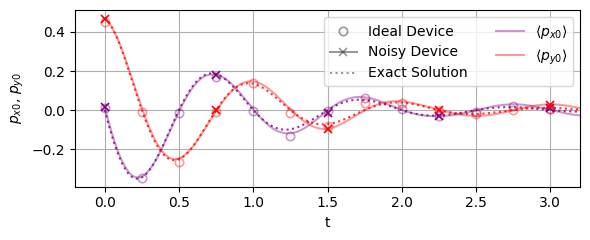

In [20]:
plt.figure(figsize=(6,2.5))
plt.plot(t_ideal_sample, px_ideal_eval, 'o', color='purple', fillstyle='none', markeredgewidth=1.2, alpha=0.4)
plt.plot(t_ideal_sample, py_ideal_eval, 'ro', fillstyle='none', markeredgewidth=1.2, alpha=0.4)
plt.plot(t_sample, px_noisy_eval, 'x', color='purple', fillstyle='none', markeredgewidth=1.2)
plt.plot(t_sample, py_noisy_eval, 'rx', fillstyle='none', markeredgewidth=1.2)
plt.plot([],[], 'ko', fillstyle='none', markeredgewidth=1.2, alpha=0.4, label='Ideal Device')
plt.plot([],[], 'kx-', fillstyle='none', markeredgewidth=1.2, alpha=0.4, label='Noisy Device')
plt.plot([],[], 'k:', alpha=0.4, label='Exact Solution')

plt.plot(t_classical, px_classical_eval, ':', color='purple', alpha=0.8)
plt.plot(t_classical, py_classical_eval, 'r:', alpha=0.8)

plt.plot(t_classical, px_interpolated, 'purple', alpha=0.4, label=r'$\langle p_{x0} \rangle$')
plt.plot(t_classical, py_interpolated, 'r', alpha=0.4, label=r'$\langle p_{y0} \rangle$')

plt.xlim((np.min(t_sample)-0.2, np.max(t_sample)+0.2))
plt.xlabel('t')
plt.ylabel('$p_{x0}$, $p_{y0}$')
plt.legend(loc='upper right', ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

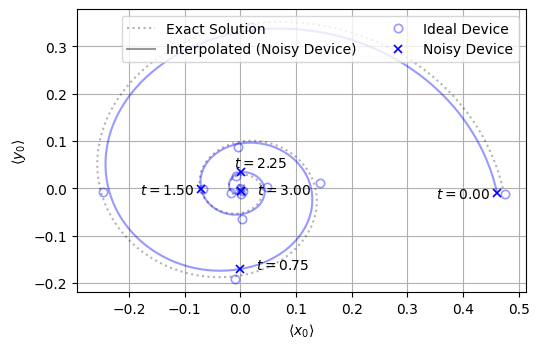

In [21]:
plt.figure(figsize=(5.5,3.6))


plt.plot(x_classical_eval, y_classical_eval, 'k:', alpha=0.3, 
         label=r'Exact Solution')
plt.plot([],[], 'k', alpha=0.4, label='Interpolated (Noisy Device)')
plt.plot(x_ideal_eval, y_ideal_eval, 'bo', fillstyle='none', markeredgewidth=1.2, alpha=0.4,
         label=r'Ideal Device')
plt.plot(x_noisy_eval, y_noisy_eval, 'bx', fillstyle='none', markeredgewidth=1.2, 
         label=r'Noisy Device')
plt.plot(x_interpolated, y_interpolated, 'b', alpha=0.4)
dxy = np.zeros((t_sample.shape[0],2))
dxy[:5] = np.array([
    [-0.02,-0.002],
    [0.005,0],
    [-0.02,-0.002],
    [-0.002,0.002],
    [0.005,-0.001],
])*5.5

for x, y, t, d in zip(x_noisy_eval, y_noisy_eval, t_sample, dxy):
    plt.text(x+d[0],y+d[1], r'$t=$'+f'{t:.2f}')
plt.xlabel(r'$\langle x_0 \rangle$')
plt.ylabel(r'$\langle y_0 \rangle$')
plt.legend(ncol=2)
plt.tight_layout()
plt.grid()
plt.show()

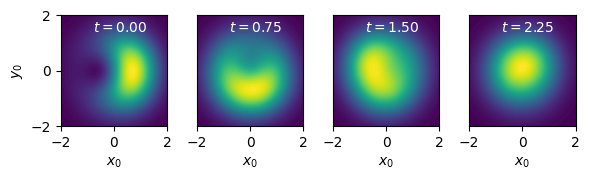

In [22]:
fig, axs = plt.subplots(1,4, figsize=(6,1.9))
for i, (t, rho, ax) in enumerate(zip(t_sample, rhos_noisy_quantum, axs.flatten())):
    sim.plot_position_density(rho,cmap='viridis', ax=ax, unitless=True)
    ax.text(-0.8,1.4, r'$t =$' + f'{t:.2f}', color='white')
    if i > 0:
        ax.set_yticks([])
        ax.set_ylabel(None)

fig.tight_layout()
plt.show()

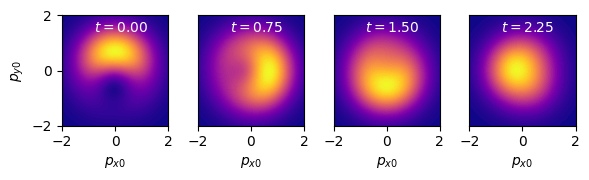

In [23]:
fig, axs = plt.subplots(1,4, figsize=(6,1.9))
for i, (t, rho, ax) in enumerate(zip(t_sample, rhos_noisy_quantum, axs.flatten())):
    sim.plot_momentum_density(rho, ax=ax, unitless=True)
    ax.text(-0.8,1.4, r'$t =$' + f'{t:.2f}', color='white')
    if i > 0:
        ax.set_yticks([])
        ax.set_ylabel(None)

fig.tight_layout()
plt.show()